## Paso 1 — Carga y comprobaciones

In [ ]:
# Cargamos cables.csv y eliminamos datos incorrectos e inecesarios
import pandas as pd
cables = pd.read_csv('cables.csv')
cables = cables.drop(columns=['Unnamed: 0'])
cables = cables.dropna()
cables = cables.drop_duplicates()

cables

,N,R,S,T,U,G,L
0,16.0,333.33,256.0,111.0,2198.0,786.0,686
1,36.0,776.67,1296.0,603.0,7491.0,914.0,2087
2,38.0,258.33,1444.0,66.0,1957.0,3234.0,734
3,76.0,863.33,5776.0,745.0,974.0,2377.0,3411
5,8.0,290.00,64.0,84.0,2731.0,587.0,358
...,...,...,...,...,...,...,...
485,29.0,1200.00,841.0,1440.0,2850.0,-413.0,3985
486,36.0,915.00,1296.0,837.0,3788.0,2457.0,1571
487,29.0,373.33,841.0,139.0,2485.0,2561.0,1682
488,40.0,450.00,1600.0,202.0,5059.0,2307.0,1663


## Paso 2 — Análisis exploratorio gráfico

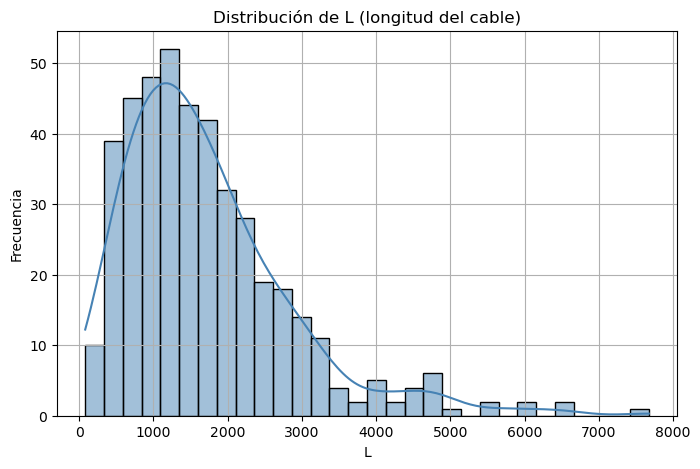

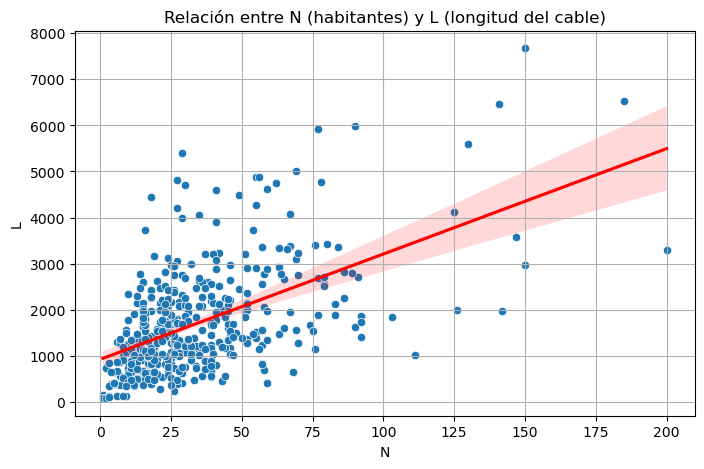

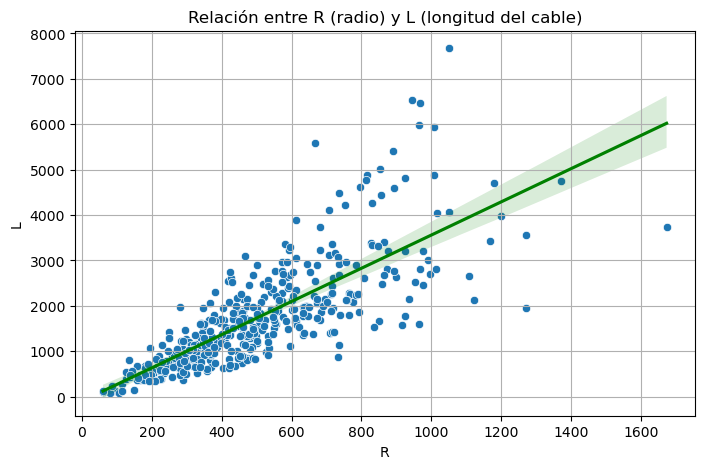

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 5))
sns.histplot(cables['L'], kde=True, bins=30, color='steelblue')
plt.title('Distribución de L (longitud del cable)')
plt.xlabel('L')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# L vs N
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables, x='N', y='L')
sns.regplot(data=cables, x='N', y='L', scatter=False, color='red')
plt.title('Relación entre N (habitantes) y L (longitud del cable)')
plt.grid(True)
plt.show()

# L vs R
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables, x='R', y='L')
sns.regplot(data=cables, x='R', y='L', scatter=False, color='green')
plt.title('Relación entre R (radio) y L (longitud del cable)')
plt.grid(True)
plt.show()

Media de N: 34.62


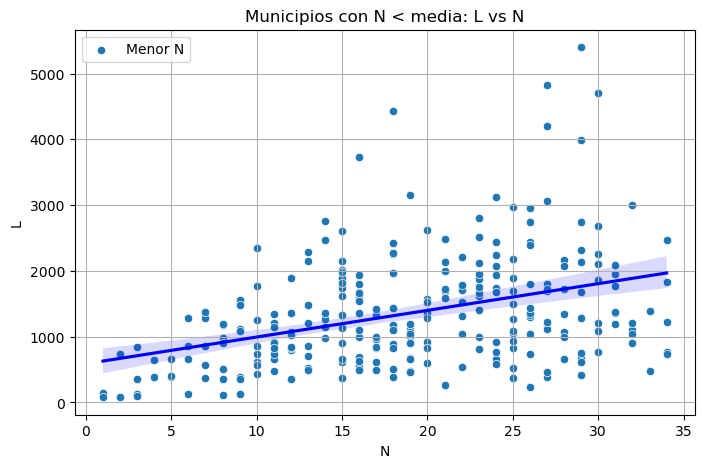

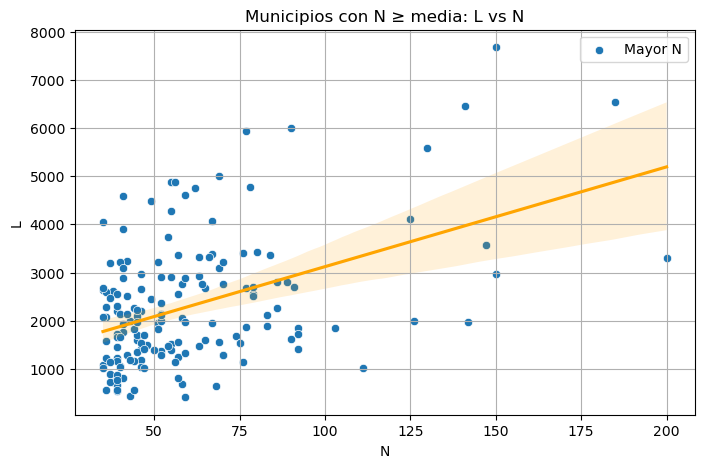

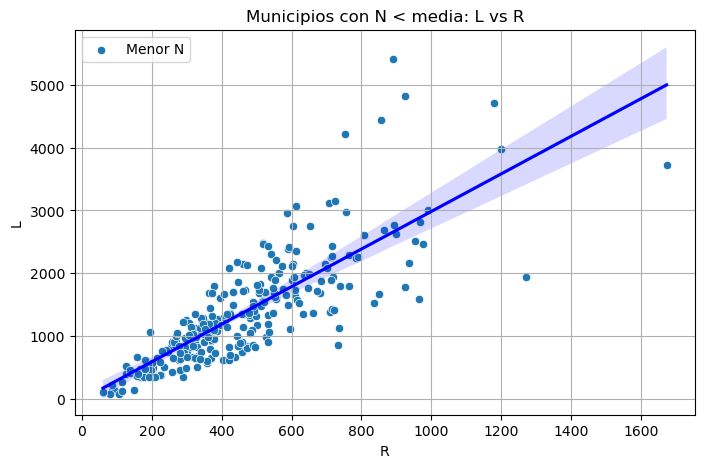

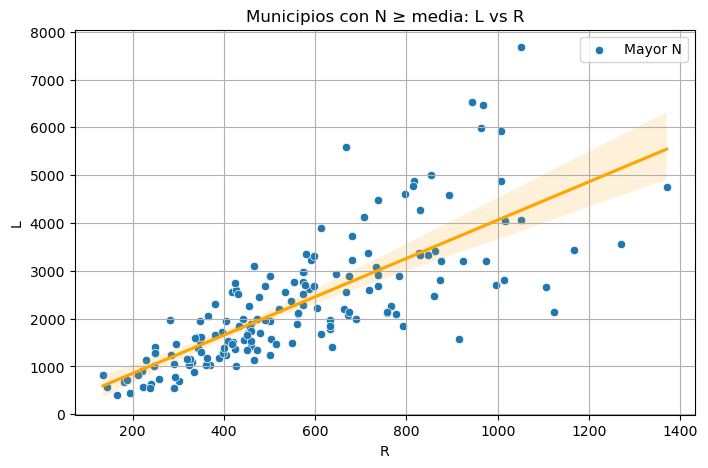

In [7]:
media_N = cables['N'].mean()
print(f"Media de N: {media_N:.2f}")

# Segmentos
cables_menores = cables[cables['N'] < media_N]
cables_mayores = cables[cables['N'] >= media_N]

# Plot: L vs N para municipios < media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_menores, x='N', y='L', label='Menor N')
sns.regplot(data=cables_menores, x='N', y='L', scatter=False, color='blue')
plt.title('Municipios con N < media: L vs N')
plt.grid(True)
plt.show()

# Plot: L vs R para municipios >= media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_mayores, x='N', y='L', label='Mayor N')
sns.regplot(data=cables_mayores, x='N', y='L', scatter=False, color='orange')
plt.title('Municipios con N ≥ media: L vs N')
plt.grid(True)
plt.show()

# Plot: L vs R para municipios < media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_menores, x='R', y='L', label='Menor N')
sns.regplot(data=cables_menores, x='R', y='L', scatter=False, color='blue')
plt.title('Municipios con N < media: L vs R')
plt.grid(True)
plt.show()

# Plot: L vs R para municipios >= media
plt.figure(figsize=(8, 5))
sns.scatterplot(data=cables_mayores, x='R', y='L', label='Mayor N')
sns.regplot(data=cables_mayores, x='R', y='L', scatter=False, color='orange')
plt.title('Municipios con N ≥ media: L vs R')
plt.grid(True)
plt.show()

Podemos observar que la tendencia es similar en ambos grupos de datos. 

In [8]:
# Outliers en L usando el método IQR
Q1 = cables['L'].quantile(0.25)
Q3 = cables['L'].quantile(0.75)
IQR = Q3 - Q1

outliers_L = cables[(cables['L'] < Q1 - 1.5 * IQR) | (cables['L'] > Q3 + 1.5 * IQR)]
print(f"Número de outliers en L: {outliers_L.shape[0]}")


Número de outliers en L: 21


## Paso 3 — Tratamiento de valores perdidos (imputación)

In [18]:
import time
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

X = cables.drop(columns='L')
y = cables['L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

res_imput = []

imp = SimpleImputer(strategy="median")
Xtr_imp = imp.fit_transform(X_train)
Xte_imp = imp.transform(X_test)

clf = LinearRegression()
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append(
    [
        "Imputación: mediana",
        Xtr_imp.shape[0],
        Xte_imp.shape[0],
        mean_squared_error(y_test, yp),
        r2_score(y_test, yp),
        t,
    ]
)

imp = KNNImputer(n_neighbors=5)
Xtr_imp = imp.fit_transform(X_train)
Xte_imp = imp.transform(X_test)
clf = LinearRegression()
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append(
    [
        "Imputación: KNN (k=5)",
        Xtr_imp.shape[0],
        Xte_imp.shape[0],
        mean_squared_error(y_test, yp),
        r2_score(y_test, yp),
        t,
    ]
)

for fila in res_imput:
    print (fila)


['Imputación: mediana', 324, 109, 268047.17749963136, 0.757141659944915, 0.0024462000001221895]
['Imputación: KNN (k=5)', 324, 109, 268047.17749963136, 0.757141659944915, 0.010566399999333953]


## Paso 4 — Escalado/normalización (si hace falta)

In [32]:
from sklearn.preprocessing import StandardScaler

X = cables.drop(columns='L')
y = cables['L']

# Quitar stratify porque y es continua
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

res_imput = []

# Imputación con mediana + escalado
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

Xtr_imp = imp.fit_transform(X_train)
Xtr_imp = scaler.fit_transform(Xtr_imp)

Xte_imp = imp.transform(X_test)
Xte_imp = scaler.transform(Xte_imp)

clf = LinearRegression()
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append([
    "Imputación: mediana + escalado",
    Xtr_imp.shape[0],
    Xte_imp.shape[0],
    mean_squared_error(y_test, yp),
    r2_score(y_test, yp),
    t,
])

# Imputación KNN + escalado
imp = KNNImputer(n_neighbors=5)
scaler = StandardScaler()

Xtr_imp = imp.fit_transform(X_train)
Xtr_imp = scaler.fit_transform(Xtr_imp)

Xte_imp = imp.transform(X_test)
Xte_imp = scaler.transform(Xte_imp)

clf = LinearRegression()
t0 = time.perf_counter()
clf.fit(Xtr_imp, y_train)
t = time.perf_counter() - t0
yp = clf.predict(Xte_imp)
res_imput.append([
    "Imputación: KNN (k=5) + escalado",
    Xtr_imp.shape[0],
    Xte_imp.shape[0],
    mean_squared_error(y_test, yp),
    r2_score(y_test, yp),
    t,
])

for fila in res_imput:
    print(fila)

['Imputación: mediana + escalado', 324, 109, 268047.1774996309, 0.7571416599449154, 0.001491899999564339]
['Imputación: KNN (k=5) + escalado', 324, 109, 268047.1774996309, 0.7571416599449154, 0.0009910999997373438]


## Paso 5 — Variables irrelevantes y outliers

In [33]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

# Asegúrate de convertir X a valores numéricos si queda alguna categórica
mi = mutual_info_regression(X, y, random_state=42)

# Crear dataframe ordenado
mi_df = pd.DataFrame({'Variable': X.columns, 'Info_Mutua': mi})
mi_df = mi_df.sort_values(by='Info_Mutua', ascending=False)
print(mi_df)

Q1 = cables['L'].quantile(0.25)
Q3 = cables['L'].quantile(0.75)
IQR = Q3 - Q1

# Definir outliers
outliers = cables[(cables['L'] < Q1 - 1.5 * IQR) | (cables['L'] > Q3 + 1.5 * IQR)]
print(f"Número de outliers en L: {outliers.shape[0]}")

  Variable  Info_Mutua
3        T    0.710915
1        R    0.699032
0        N    0.178754
2        S    0.164932
4        U    0.056851
5        G    0.000000
Número de outliers en L: 21
